In [521]:
import pandas as pd
import numpy as np
import json

In [526]:
# change the path for other waves of data - also adapt the bins of the histograms (the maximum values and ranges)
primary_school = '../data/Buzz_W5_primary-schools.csv'
secondary_school = '../data/Buzz_W5_secondary-schools.csv'

In [527]:
df_comm = pd.read_csv(primary_school, sep=';', header=0)
df_comm = df_comm.append(pd.read_csv(secondary_school, sep=';', header=0))
df_comm.shape

(174524, 30)

In [528]:
#surpress the scientific notation format that's shown by default
pd.set_option('display.float_format', lambda x: '%.0f' % x)

###### comment out if you want to see only data from selected classes

In [529]:
# try:
#     input_args = json.loads(open('../input/simulation.json').read())
# except Exception as ex:
#     print('simulation.json does not exist!')
#     print(ex)

# classes = input_args["classes"]
# df_comm = df_comm[df_comm.Class.isin(classes)]

In [530]:
df_comm.columns

Index(['Participant', 'School', 'Class', 'Child', 'Gender', 'Age', 'PI',
       'Date', 'Time', 'UMID', 'Format_text', 'Format_Media', 'Type',
       'RecipientChild', 'ClassReceive', 'Content', 'Media', 'ReactionInto',
       'Flagged', 'PostedWhileBanned', 'ShareSource', 'SharedVia',
       'Number_likes', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29'],
      dtype='object')

In [531]:
df_comm.groupby(["Type"])['Type'].count()

Type
group       38529
my          32677
mymovez    103318
Name: Type, dtype: int64

In [532]:
df_comm_group = df_comm[df_comm.Type=="group"]
df_comm_group.shape

(38529, 30)

In [533]:
df_comm_ind = df_comm[df_comm.Type=="my"]
df_comm_ind.shape

(32677, 30)

### Messages exchanged between individuals

In [534]:
df_comm_ind['Class'].nunique(),df_comm_ind['Child'].nunique(),df_comm_ind['RecipientChild'].nunique()

(44, 617, 685)

In [535]:
df_comm_ind.groupby(["Class"])["Child"].nunique()

Class
73      1
74      1
78     18
81     19
82      8
86      5
100    19
103    11
124    17
125    16
131     9
133    10
134     7
135    12
141     8
250     7
251    12
256    24
258    16
259    14
261    17
262    15
263    20
272    25
273    24
277    10
279     9
290    13
291    13
292    21
296    17
297    16
298    21
299    19
300    19
301    24
302    19
303    25
304     5
305     5
306     8
307    12
308    14
310    12
Name: Child, dtype: int64

In [537]:
df_messages_per_child = df_comm_ind.groupby("Child")["UMID"].count().reset_index()
df_messages_per_child

,Child,UMID
0,1409,4
1,1605,5
2,1606,2
3,1607,10
4,1608,16
...,...,...
612,6178,11
613,6179,2
614,6180,8
615,6181,5


In [538]:
df_messages_per_child['UMID'].describe()

count   617
mean     53
std      97
min       1
25%       5
50%      17
75%      50
max     789
Name: UMID, dtype: float64

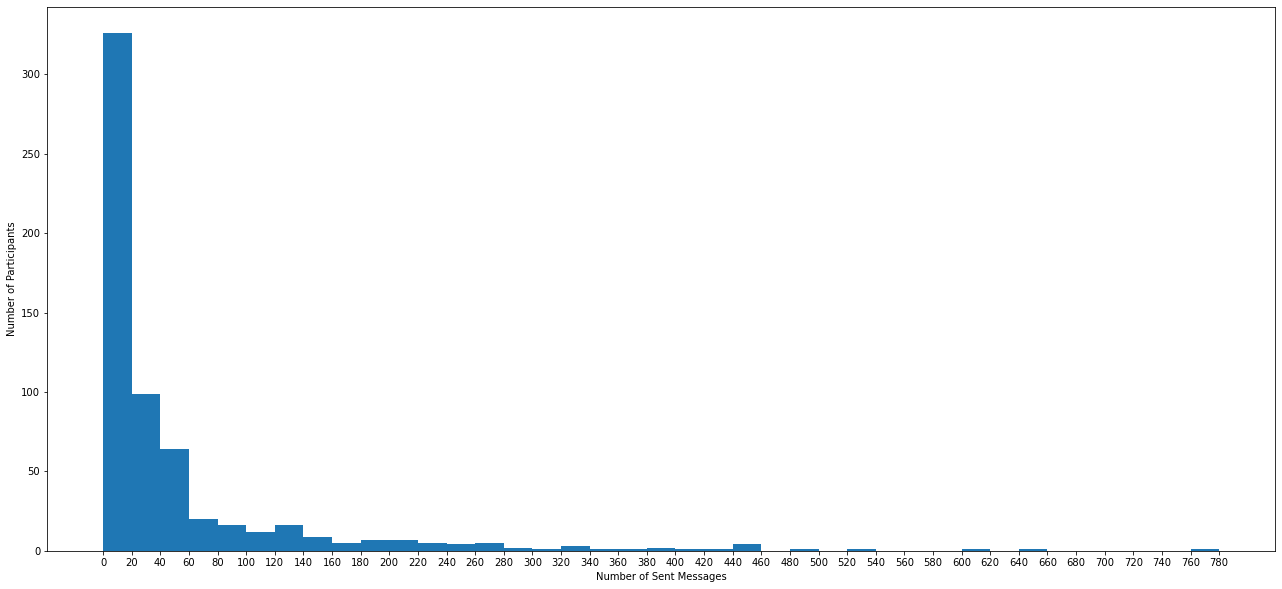

In [541]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(0,790,20)
plt.xticks(bins)
df_comm_ind.groupby("Participant")["UMID"].count().plot.hist(bins=bins)
ax.set_xlabel('Number of Sent Messages')
ax.set_ylabel('Number of Participants')
plt.show()

In [542]:
pairs_freq = df_comm_ind.groupby(["Participant","RecipientChild"])["UMID"].count().reset_index(name='NumberMessages')
pairs_freq

,Participant,RecipientChild,NumberMessages
0,2607301409,2607301406,4
1,2607404365,2607401422,2
2,2807801633,2807801641,1
3,2807801633,2807801644,2
4,2807801633,2807801645,3
...,...,...,...
4052,6031006181,6031006171,3
4053,6031006181,6031006172,1
4054,6031006181,6031006173,1
4055,6031006182,6031006162,1


In [543]:
pairs_freq = pairs_freq.astype({'Participant': 'float64'})

In [548]:
pairs = []
values = []
exchanged_messages = []
for line in pairs_freq[["Participant","RecipientChild", "NumberMessages"]].iterrows():
    (p1, p2, var) = line[1]
    if(p1, p2) not in pairs and (p2, p1) not in pairs:
        pairs.append((p1,p2))
        values.append((var))

    elif (p2, p1) in pairs:
        # get the index of this pair and update in the values of the same index
        ind = pairs.index((p2,p1))
        values[ind] = (values[ind] + var)

# print('found pairs',pairs)
# print('found values',values)


count = 0
for line in pairs:
    (pp1, pp2) = line
    exchanged_messages.append((pp1,pp2,values[count]))
    count = count + 1

exchanged_messages = pd.DataFrame(exchanged_messages, columns = ["P1", "P2", "NumMes"])
exchanged_messages

,P1,P2,NumMes
0,2607301409,2607301406,4
1,2607404365,2607401422,2
2,2807801633,2807801641,1
3,2807801633,2807801644,2
4,2807801633,2807801645,7
...,...,...,...
2464,6031006177,6031006179,2
2465,6031006178,6031006180,11
2466,6031006179,6031006185,1
2467,6031006181,6031006171,3


In [549]:
exchanged_messages["NumMes"].describe()

count   2469
mean      13
std       37
min        1
25%        2
50%        4
75%       10
max      637
Name: NumMes, dtype: float64

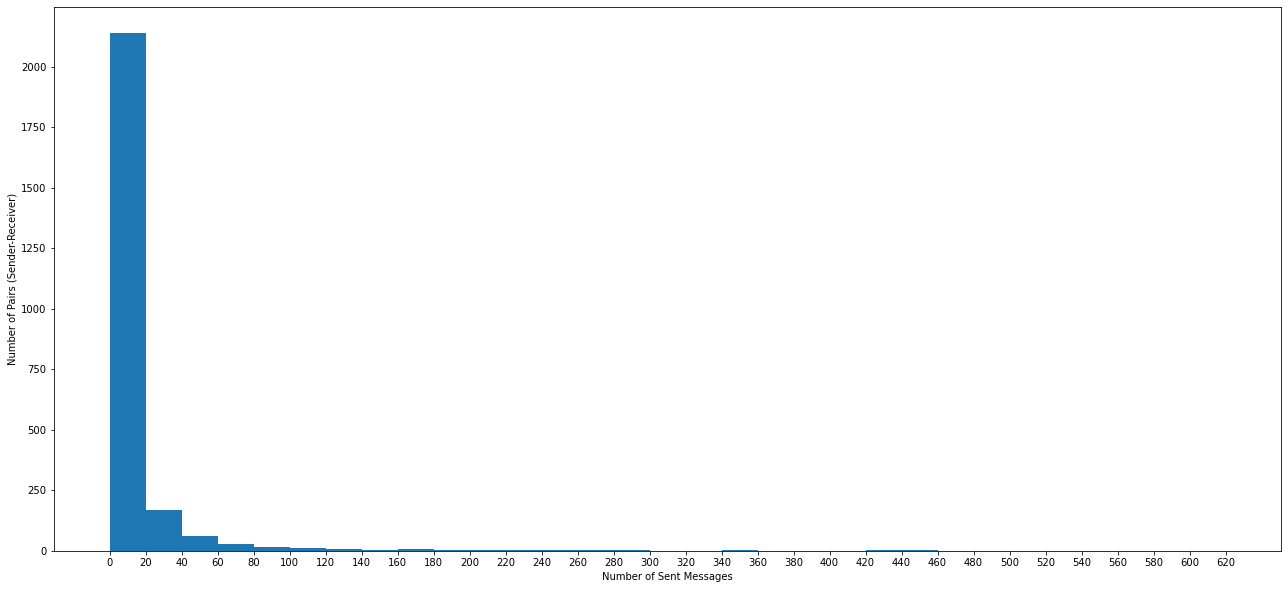

In [551]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(0,640,20)
plt.xticks(bins)
exchanged_messages["NumMes"].plot.hist(bins=bins)
ax.set_xlabel('Number of Sent Messages')
ax.set_ylabel('Number of Pairs (Sender-Receiver)')
plt.show()

In [552]:
df_ind_images = df_comm_ind.groupby(["Participant","Format_Media"])["UMID"].count().reset_index(name = "NumberImages")
df_ind_images.head()

,Participant,Format_Media,NumberImages
0,2807801633,image,1
1,2807801633,video,5
2,2807801636,video,1
3,2807801637,image,2
4,2807801637,video,1


In [553]:
df_ind_images['NumberImages'].describe()

count   571
mean      5
std      10
min       1
25%       1
50%       2
75%       5
max     120
Name: NumberImages, dtype: float64

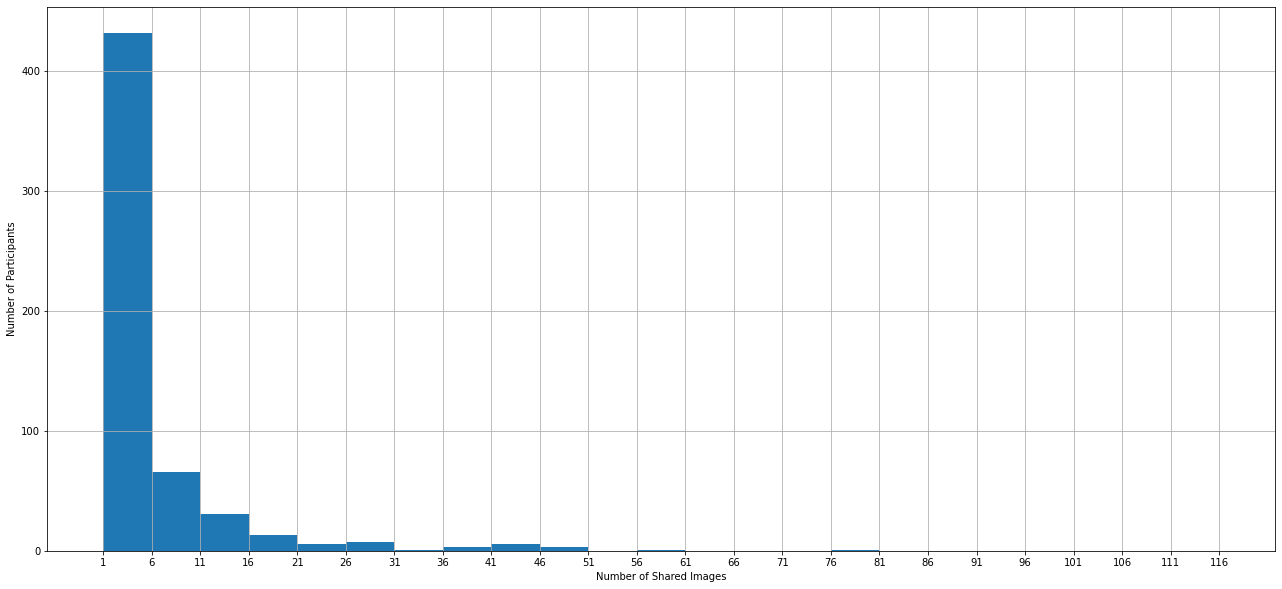

In [557]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(1,120,5)
plt.xticks(bins)
df_ind_images['NumberImages'].hist(bins=bins)
ax.set_xlabel('Number of Shared Images')
ax.set_ylabel('Number of Participants')
plt.show()

In [558]:
df_comm_ind['Date'].unique()

array(['9-3-2018', '10-3-2018', '11-3-2018', '13-3-2018', '15-3-2018',
       '14-3-2018', '12-3-2018', '27-2-2018', '28-2-2018', '1-3-2018',
       '2-3-2018', '4-3-2018', '3-3-2018', '5-3-2018', '22-3-2018',
       '23-3-2018', '21-3-2018', '24-3-2018', '25-3-2018', '26-3-2018',
       '27-3-2018', '20-3-2018', '18-3-2018', '17-3-2018', '16-3-2018',
       '19-3-2018', '7-3-2018', '8-3-2018', '6-3-2018', '15-2-2018',
       '16-2-2018', '17-2-2018', '18-2-2018', '20-2-2018', '19-2-2018',
       '21-2-2018', '28-3-2018', '29-3-2018', '22-2-2018', '26-2-2018',
       '23-2-2018', '25-2-2018'], dtype=object)

In [559]:
df_comm_ind.groupby(['Date'])['UMID'].count().reset_index()

,Date,UMID
0,1-3-2018,2002
1,10-3-2018,805
2,11-3-2018,352
3,12-3-2018,310
4,13-3-2018,755
5,14-3-2018,719
6,15-2-2018,1241
7,15-3-2018,833
8,16-2-2018,1185
9,16-3-2018,669


### Group messages

In [560]:
df_comm_ind.groupby(["Class"])["Participant"].nunique()

Class
73      1
74      1
78     18
81     19
82      8
86      5
100    19
103    11
124    17
125    16
131     9
133    10
134     7
135    12
141     8
250     7
251    12
256    24
258    16
259    14
261    17
262    15
263    20
272    25
273    24
277    10
279     9
290    13
291    13
292    21
296    17
297    16
298    21
299    19
300    19
301    24
302    19
303    25
304     5
305     5
306     8
307    12
308    14
310    12
Name: Participant, dtype: int64

In [561]:
df_group_messages_per_child = df_comm_group.groupby("Child")["UMID"].count().reset_index()
df_group_messages_per_child.head()

,Child,UMID
0,1209,3
1,1401,2
2,1406,2
3,1408,1
4,1409,3


In [562]:
df_group_messages_per_child['UMID'].describe()

count   675
mean     57
std      84
min       1
25%       6
50%      19
75%      76
max     539
Name: UMID, dtype: float64

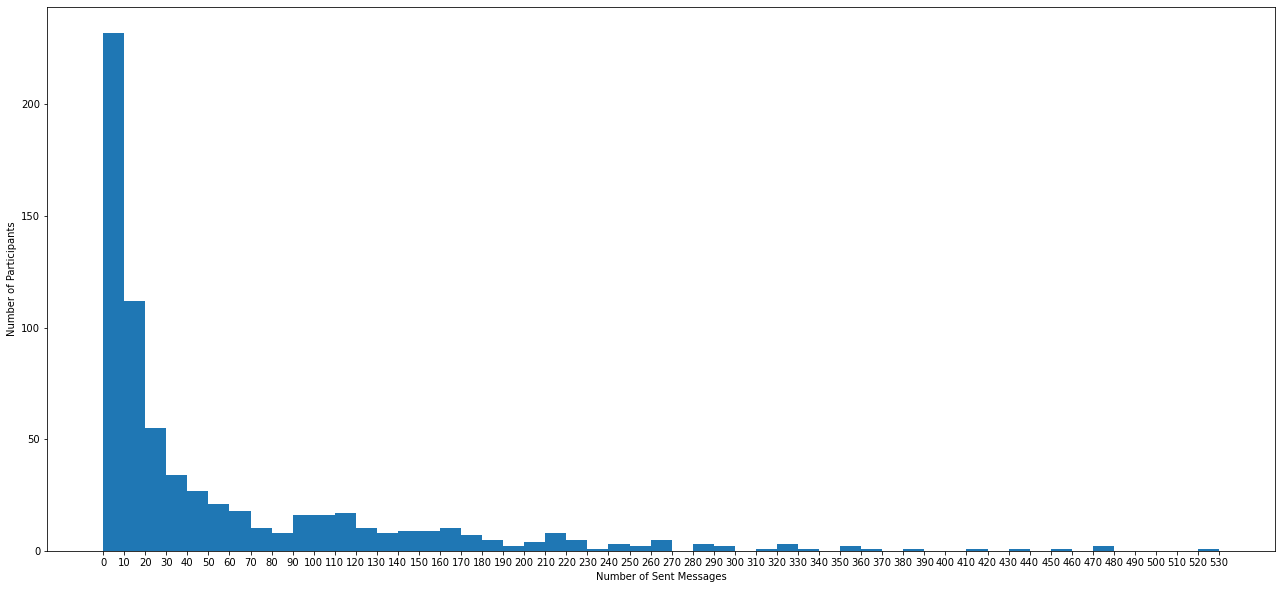

In [564]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(0,540,10)
plt.xticks(bins)
df_group_messages_per_child['UMID'].plot.hist(bins=bins)
ax.set_xlabel('Number of Sent Messages')
ax.set_ylabel('Number of Participants')
plt.show()

In [566]:
df_comm_group = df_comm_group.astype({'Number_likes': 'int32'})

In [567]:
df_child_like = df_comm_group.groupby(['Child'])['Number_likes'].sum().reset_index()

In [568]:
df_child_like['Number_likes'].describe()

count   675
mean     11
std      17
min       0
25%       1
50%       5
75%      13
max     191
Name: Number_likes, dtype: float64

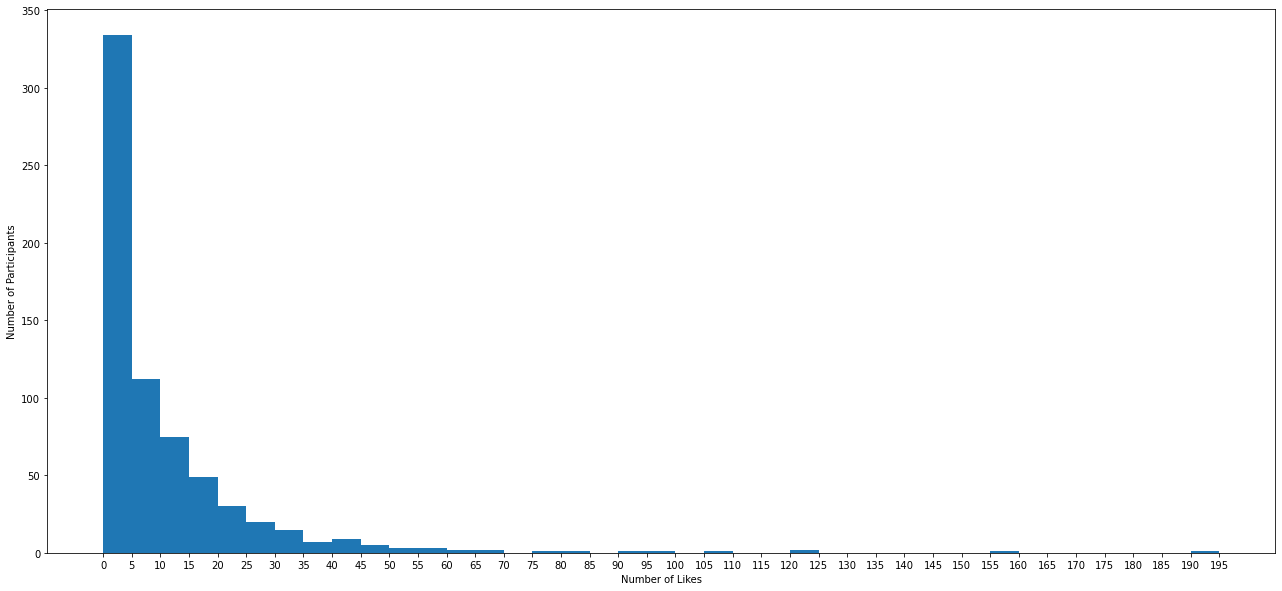

In [569]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(0,200,5)
plt.xticks(bins)
df_child_like['Number_likes'].plot.hist(bins=bins)
ax.set_xlabel('Number of Likes')
ax.set_ylabel('Number of Participants')
plt.show()

In [570]:
# images exhanged in group vs peer-to-peer communication
df_comm_group['Format_Media'].count(),df_comm_ind['Format_Media'].count()

(4576, 3110)

In [571]:
df_group_images = df_comm_group.groupby(["Participant","Format_Media"])["UMID"].count().reset_index(name = "NumberImages")
df_group_images.head()

,Participant,Format_Media,NumberImages
0,2506601209,image,1
1,2607301406,image,1
2,2607401414,image,2
3,2607401424,image,1
4,2607401424,video,1


In [572]:
df_group_images['NumberImages'].describe()

count   814
mean      6
std       8
min       1
25%       1
50%       3
75%       6
max     126
Name: NumberImages, dtype: float64

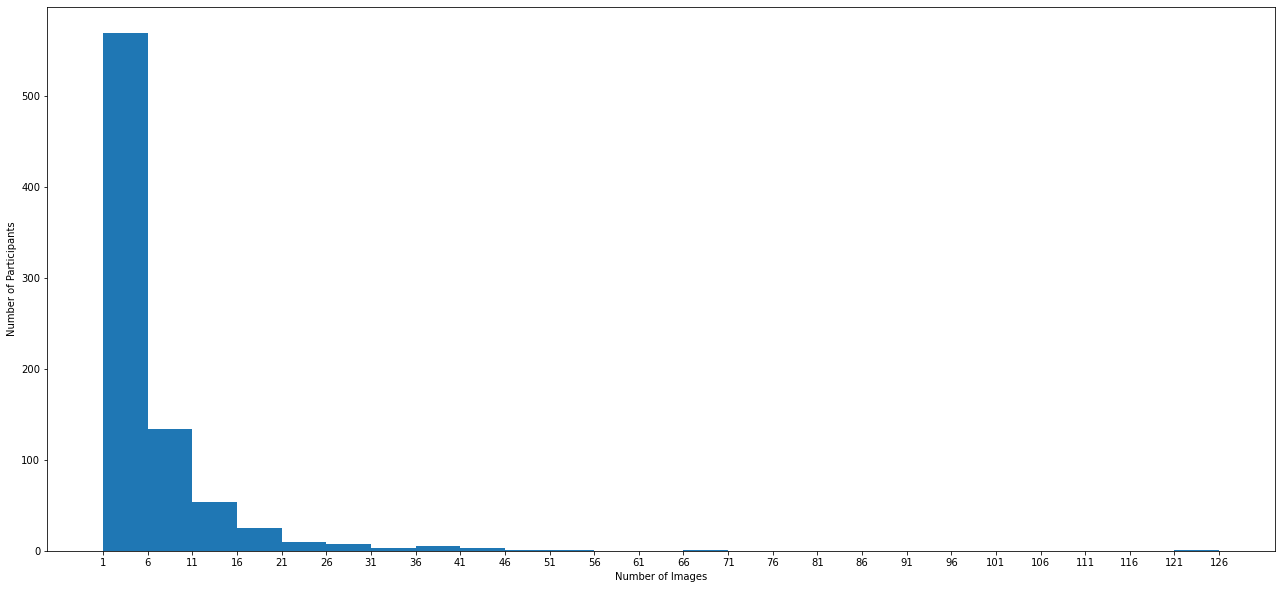

In [573]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(22, 10)
bins = range(1,130,5)
plt.xticks(bins)
df_group_images['NumberImages'].plot.hist(bins=bins)
ax.set_xlabel('Number of Images')
ax.set_ylabel('Number of Participants')
plt.show()